In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:

# ==========================================
# 1. Data Preparation
# ==========================================
# Load the dataset
file_path = 'ORB04_EUR_EPHIO.csv'
df = pd.read_csv(file_path)

# Extract inputs (Spatial Coordinates) and outputs (Magnetic Field)
# Inputs: X, Y, Z
# Outputs: BX, BY, BZ
X_raw = df[['X', 'Y', 'Z']].values
y_raw = df[['BX', 'BY', 'BZ']].values

# Normalization (Crucial for Tanh activation and PINNs)
# We scale everything to [-1, 1]
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = MinMaxScaler(feature_range=(-1, 1))

X_scaled = input_scaler.fit_transform(X_raw)
y_scaled = output_scaler.fit_transform(y_raw)

# Convert to PyTorch Tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Split into Training and Validation sets (80/20 split)
X_train, X_val, y_train, y_val = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)


In [4]:

# ==========================================
# 2. Neural Network Architecture
# ==========================================
class MagneticFieldNN(nn.Module):
    def __init__(self):
        super(MagneticFieldNN, self).__init__()
        # Architecture based on Baty/Raissi:
        # ~4-7 hidden layers, ~20-40 neurons, Tanh activation
        self.net = nn.Sequential(
            nn.Linear(3, 32),    # Input Layer (X, Y, Z) -> Hidden 1
            nn.Tanh(),
            nn.Linear(32, 32),   # Hidden 2
            nn.Tanh(),
            nn.Linear(32, 32),   # Hidden 3
            nn.Tanh(),
            nn.Linear(32, 32),   # Hidden 4
            nn.Tanh(),
            nn.Linear(32, 32),   # Hidden 5
            nn.Tanh(),
            nn.Linear(32, 3)     # Output Layer (BX, BY, BZ)
        )

    def forward(self, x):
        return self.net(x)

# Initialize Model, Optimizer, and Loss
model = MagneticFieldNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Learning rate 0.001
criterion = nn.MSELoss()


In [5]:

# ==========================================
# 3. Training Loop
# ==========================================
epochs = 5000  # Set to 40,000+ for full convergence
train_losses = []
val_losses = []

print(f"Starting training for {epochs} epochs...")

for epoch in range(epochs):
    model.train()

    # Forward pass
    predictions = model(X_train)
    loss = criterion(predictions, y_train)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation step (No gradient calculation)
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val)

    # Store history
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {loss.item():.6f} | Val Loss: {val_loss.item():.6f}")


Starting training for 5000 epochs...
Epoch [500/5000] | Train Loss: 0.008633 | Val Loss: 0.008649
Epoch [1000/5000] | Train Loss: 0.007720 | Val Loss: 0.007627
Epoch [1500/5000] | Train Loss: 0.006699 | Val Loss: 0.006476
Epoch [2000/5000] | Train Loss: 0.006154 | Val Loss: 0.005880
Epoch [2500/5000] | Train Loss: 0.005284 | Val Loss: 0.004928
Epoch [3000/5000] | Train Loss: 0.005044 | Val Loss: 0.004672
Epoch [3500/5000] | Train Loss: 0.004823 | Val Loss: 0.004453
Epoch [4000/5000] | Train Loss: 0.004643 | Val Loss: 0.004285
Epoch [4500/5000] | Train Loss: 0.004495 | Val Loss: 0.004134
Epoch [5000/5000] | Train Loss: 0.004354 | Val Loss: 0.004008


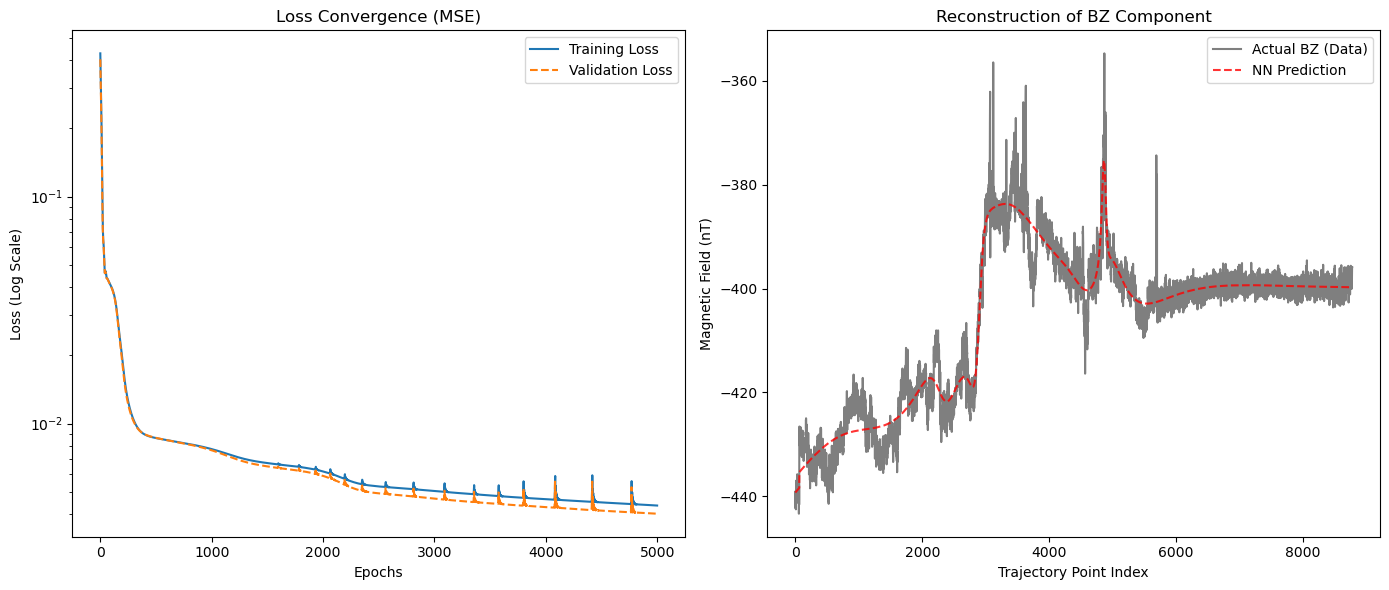

Model saved as europa_mag_field_nn.pth


In [6]:

# ==========================================
# 4. Visualization & Evaluation
# ==========================================
plt.figure(figsize=(14, 6))

# Plot 1: Convergence
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.yscale('log')
plt.title('Loss Convergence (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log Scale)')
plt.legend()

# Plot 2: Function Approximation Performance (BZ Component)
# Predict on the full dataset to see the trajectory reconstruction
model.eval()
with torch.no_grad():
    all_preds_scaled = model(X_tensor)
    # Inverse transform to get back to nanotesla (nT)
    all_preds = output_scaler.inverse_transform(all_preds_scaled.numpy())

# Sorting by index to plot essentially "vs Time"
plt.subplot(1, 2, 2)
plt.plot(y_raw[:, 2], 'k-', alpha=0.5, label='Actual BZ (Data)')
plt.plot(all_preds[:, 2], 'r--', alpha=0.8, label='NN Prediction')
plt.title('Reconstruction of BZ Component')
plt.xlabel('Trajectory Point Index')
plt.ylabel('Magnetic Field (nT)')
plt.legend()

plt.tight_layout()
plt.savefig("europa_mag_field_nn_performance.png", dpi=300)
plt.show()

# Save the model state for later PINN use
torch.save(model.state_dict(), 'europa_mag_field_nn.pth')
print("Model saved as europa_mag_field_nn.pth")